In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

import nfp

In [3]:
df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20210216_fixed_rl_redox_data.csv')
df.head()

,ionization energy,electron affinity,err_smiles,smiles
0,0.913684,-0.292055,C#CC1=C(C(C)C)C(C2CC2)=C([O])CC1,C#CC1=C(C(C)C)C(C2CC2)=C([O])CC1
1,1.066037,-0.326042,C#C[CH]C(C)=C(C(=O)O)C(C)(C)C,C#C[CH]/C(C)=C(\C(=O)O)C(C)(C)C
2,NaN,-0.382259,CC(=C(C=C([O])O)C(C)(C)C)C(C)(C)C,C/C(=C(/C=C(\[O])O)C(C)(C)C)C(C)(C)C
3,0.844432,-0.547755,CC(=C(C(O)=C[O])C(C)(C)C)C(C)(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)(C)C
4,0.843045,-0.576871,CC(=C(C(O)=C[O])C(C)(C)C)C(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)C


In [5]:
import sys
sys.path.append('..')

from rdkit import Chem
from alphazero.preprocessor import preprocessor

redox_model_orig = tf.keras.models.load_model(
    '/projects/rlmolecule/pstjohn/models/20210214_redox/',
    compile=False)

dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(Chem.MolFromSmiles(smiles), train=False)
             for smiles in df.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

new_preds_with_orig_data = redox_model_orig.predict(dataset, verbose=1)

29/29 [==============================] - 3s 103ms/step


In [6]:
len(df.smiles.unique())

3698

In [7]:
# The original model predictions aren't super trustworthy, so we repredict with a model
# trained on only the original data, and down-select again for those that slightly cross
# the decision thresholds
df['pred ionization energy'] = new_preds_with_orig_data[:, 0]
df['pred electron affinity'] = new_preds_with_orig_data[:, 1]

df['V_diff_pred'] = df['pred ionization energy'] - df['pred electron affinity']

df_pred_pass = df[(df['pred electron affinity'] > -.5) &
        (df['pred ionization energy'] < 1.2) &
        (df['V_diff_pred'] > 1)]

print(f"fraction passing: {len(df_pred_pass) / len(df):.3f}")

df = df_pred_pass.copy()

fraction passing: 0.755


In [8]:
len(df.smiles.unique())

2793

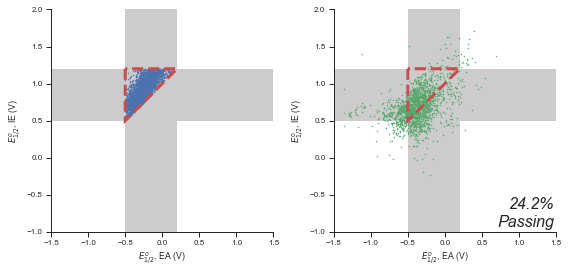

In [9]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=1, rasterized=True)
ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1, 2])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax2 = fig.add_subplot(122, aspect='equal')
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=1, color='g', rasterized=True)
ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1, 2])

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df_pass = df[(df['electron affinity'] > -.5) &
        (df['ionization energy'] < 1.2) &
        (df['V_diff'] > 1)]

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='16', style='italic')

sns.despine()
plt.tight_layout()
# plt.savefig('redox_dft_confirmation.svg')

In [10]:
df_pass.shape[0] / df.dropna(subset=['V_diff']).shape[0]

0.3918840579710145

In [26]:
df_spin = pd.read_csv('shrees_attachments/20210109_dft_ml_spin_bv_data.csv.gz')
# df_spin = df_spin.merge(df, left_on='smiles', right_on='err_smiles', how='inner').drop(
#     'smiles_x', 1).rename(columns={'smiles_y': 'smiles'})
# df_spin.head()
len(df_spin.smiles.unique())

3762

In [62]:
df_spin = df_spin.merge(df, left_on='smiles', right_on='err_smiles', how='inner'
                       ).drop('smiles_x', 1).rename(columns={'smiles_y': 'smiles'})

len(df_spin.smiles.unique())

2793

In [64]:
stability_orig = tf.keras.models.load_model(
    '/projects/rlmolecule/pstjohn/models/20210214_radical_stability_new_nfp/',
    compile=False)

spins, bur_vols = stability_orig.predict(dataset, verbose=1)

22/22 [==============================] - 2s 84ms/step


In [65]:
spins_df = pd.DataFrame(spins, index=df.smiles).reset_index().melt(id_vars='smiles', var_name='atom_index', value_name='pred fractional spin')
bur_vols_df = pd.DataFrame(bur_vols.squeeze(), index=df.smiles).reset_index().melt(id_vars='smiles', var_name='atom_index', value_name='pred buried vol')

spins_df['pred buried vol'] = bur_vols_df['pred buried vol']
spins_df = spins_df[spins_df['pred fractional spin'] != 0]

In [66]:
df_spin_merged = df_spin.merge(spins_df, on=['smiles', 'atom_index'], how='left')
df_spin_merged = df_spin_merged.drop([' pred buried_vol', 'pred fractional_spin'], 1)  # drop original predictions

In [67]:
import rdkit 
def get_atom_symbols():
    for smiles in df_spin.smiles.unique():
        mol = rdkit.Chem.MolFromSmiles(smiles)
        for i, atom in enumerate(mol.GetAtoms()):
            yield pd.Series({
                'smiles': smiles,
                'atom_index': i,
                'atom_symbol': atom.GetSymbol()})

In [68]:
atom_symbol_df = pd.DataFrame(get_atom_symbols())

In [69]:
df_spin_symbol = df_spin_merged.merge(atom_symbol_df, on=['smiles', 'atom_index'])

In [70]:
(df_spin_symbol.groupby('smiles').fractional_spin.idxmax() == df_spin_symbol.groupby('smiles')['pred fractional spin'].idxmax()).mean()

0.8177586824203366

In [71]:
bur_vol_dft = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x.fractional_spin.idxmax()].buried_vol)
bur_vol_ml = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x['pred fractional spin'].idxmax()]['pred buried vol'])

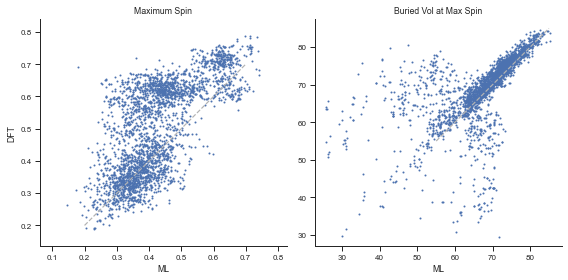

In [72]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal', adjustable='datalim')

ax1.plot(
    df_spin_symbol.groupby('smiles')['pred fractional spin'].max(),
    df_spin_symbol.groupby('smiles').fractional_spin.max(),
    '.', ms=2)

ax1.plot([.2, .7], [.2, .7], '--', color='.7')

ax2 = fig.add_subplot(122, aspect='equal', adjustable='datalim')
ax2.plot(bur_vol_ml, bur_vol_dft, '.', ms=2)

ax2.plot([55, 85], [55, 85], '--', color='.7')
ax1.set_ylabel('DFT')
ax1.set_xlabel('ML')
ax2.set_xlabel('ML')

ax1.set_title('Maximum Spin')
ax2.set_title('Buried Vol at Max Spin')


sns.despine()
plt.tight_layout()

In [73]:
def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    
    score_dft = bur_vol + 50 * (1 - spin)
    
    idxmax = x['pred fractional spin'].idxmax()
    spin = x['pred fractional spin'].max()
    bur_vol = x.loc[idxmax]['pred buried vol']
    
    score_pred = bur_vol + 50 * (1 - spin)
    return pd.Series({'dft': score_dft, 'pred': score_pred})

stability_scores = df_spin_symbol.groupby('smiles').apply(stability_score)

In [78]:
redox_data = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')

In [79]:
redf_baseline = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/20210118_bde_baseline_spin_burvol.csv.gz')

def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    return bur_vol + 50 * (1 - spin)

bde_db_stability_scores = redf_baseline.groupby('smiles').apply(stability_score)

In [89]:
stability_scores = stability_scores[stability_scores.pred > 100]
df = df[df.smiles.isin(stability_scores[stability_scores.pred > 100].index)]

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


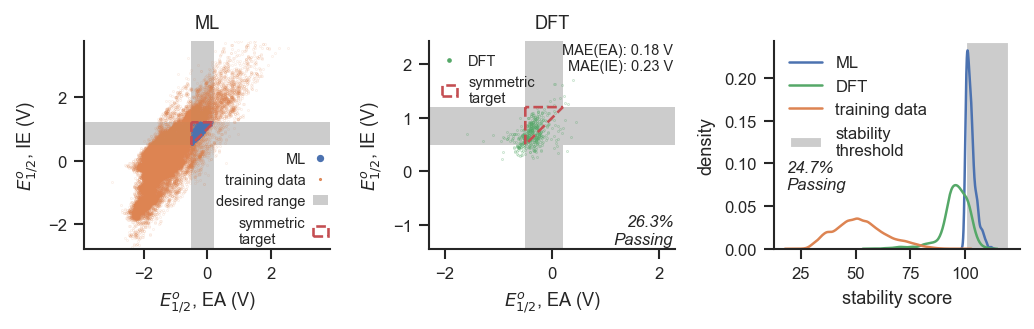

In [91]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(7,2.3), dpi=150)
ax1 = fig.add_subplot(131, aspect='equal', adjustable='datalim')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=.5, rasterized=True, color='b', zorder=3, label='ML')
ax1.plot(redox_data['electron affinity'], redox_data['ionization energy'], '.', ms=.1,
         rasterized=True, color=sns.color_palette()[1], zorder=1, label='training data')

ax1.set_xlim([-3, 3])
ax1.set_ylim([-2, 3])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0, label='desired range')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none',
                      zorder=5, edgecolor='r', lw=1.25, ls='--', label='symmetric\ntarget'))

ax1.legend(loc='lower right', markerfirst=False, markerscale=10, fontsize=7, borderpad=0,
           borderaxespad=0.2, handlelength=1, handletextpad=.5)

ax2 = fig.add_subplot(132, aspect='equal', adjustable='datalim')

df_nona = df.dropna(subset=['ionization energy', 'electron affinity'])
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=.25, color='g', rasterized=True, zorder=3, label='DFT')

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none', zorder=0)
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none', zorder=0)


ax2.set_xlim([-3, 3])
ax2.set_ylim([-2, 3])

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

# ax2.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
# ax2.yaxis.offsetText.set_visible(False)


ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none',
                      zorder=5, edgecolor='r', lw=1.25, ls='--', label='symmetric\ntarget'))

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df['pass_redox'] = ((df['electron affinity'] > -.5) &
                    (df['ionization energy'] < 1.2) &
                    (df['V_diff'] > 1))

df_pass = df[df.pass_redox]

df_with_stability = df.merge(stability_scores, left_on='smiles', right_index=True)

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='8', style='italic')


ax2.text(.99, .99, f"MAE(EA): {(df['pred electron affinity'] - df['electron affinity']).abs().mean():.2f} V\n"
         f"MAE(IE): {(df['pred ionization energy'] - df['ionization energy']).abs().mean():.2f} V",
         ha='right', va='top', fontsize='7', transform=ax2.transAxes, )
# ax2.text(.99, .99, f", ha='right', va='top', fontsize='7', transform=ax2.transAxes, )

ax2.legend(loc='upper left', handlelength=1, markerscale=10, fontsize=7)


ax3 = fig.add_subplot(133)
sns.kdeplot(stability_scores['pred'], color='b', label='ML')
sns.kdeplot(stability_scores['dft'], color='g', label='DFT')
sns.kdeplot(bde_db_stability_scores, color=sns.color_palette()[1], label='training data')

# ax3.axvline(100, ls='--', color='r', lw=1.5)
ax3.axvspan(100, 120, facecolor='.8', lw=1.5, label='stability\nthreshold')

ax3.legend(loc='upper left')


ax3.text(.05, .35, f"{(stability_scores['dft'] > 100).mean():.1%}\nPassing",
         ha='left', va='center', transform=ax3.transAxes, fontsize='8', style='italic')

ax3.set_xticks([25, 50, 75, 100,])

plt.ylabel('density')
plt.xlabel('stability score')

ax1.set_title('ML')
ax2.set_title('DFT')

sns.despine()
plt.tight_layout()
plt.savefig('fig4_dft_confirmation.svg')

In [92]:
df_with_stability

,ionization energy,electron affinity,err_smiles,smiles,pred ionization energy,pred electron affinity,V_diff_pred,V_diff,pass_redox,dft,pred
4,0.843045,-0.576871,CC(=C(C(O)=C[O])C(C)(C)C)C(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)C,0.559023,-0.463751,1.022774,1.419916,False,85.102481,100.055583
5,0.677467,-0.235511,CC([O])=C(C(O)=C(C)C(C)C)C(C)(C)C,C/C(=C(O)\C(=C(/C)[O])C(C)(C)C)C(C)C,0.776560,-0.270637,1.047196,0.912978,False,91.446961,102.624856
30,NaN,-0.346912,CC(C(N)=O)=C(C)C(=C([O])O)C(C)(C)C,C/C(C(N)=O)=C(C)\C(=C(\[O])O)C(C)(C)C,1.166698,-0.062621,1.229319,NaN,False,88.911179,100.988925
32,1.222826,-0.089117,CC(C=O)=C(C)C(=C([O])C1CC1)C(C)C,C/C(C=O)=C(C)/C(=C(/[O])C1CC1)C(C)C,1.186033,-0.024895,1.210928,1.311943,False,93.541714,100.276147
33,NaN,-0.165688,CC([O])=C(C(C)=C(C)C=O)C(C)(C)C,C/C(C=O)=C(C)/C(=C(\C)[O])C(C)(C)C,1.058777,-0.011063,1.069840,NaN,False,93.663145,108.651088
...,...,...,...,...,...,...,...,...,...,...,...
3638,1.230853,0.032216,C[CH]C1=C(C(C)(C)N)C(C)=CC(=O)C1=O,C[CH]C1=C(C(C)(C)N)C(C)=CC(=O)C1=O,1.016252,-0.324794,1.341046,1.198637,False,101.511778,104.959697
3639,1.132976,NaN,C[CH]C1=C(C(C)C)C(C)=CC(=O)C1=S,C[CH]C1=C(C(C)C)C(C)=CC(=O)C1=S,0.958905,-0.384599,1.343504,NaN,False,98.583733,103.010062
3648,0.473440,-0.661470,Cc1c(C(C)(C)C)c([O])n2c1CC(=O)C2,Cc1c(C(C)(C)C)c([O])n2c1CC(=O)C2,0.721269,-0.321654,1.042923,1.134909,False,88.308906,100.017518
3679,0.818310,-0.379184,O=C1OCC=C2CC[CH]C(CCCS)=C12,O=C1OCC=C2CC[CH]C(CCCS)=C12,0.803640,-0.352650,1.156290,1.197494,True,97.037679,100.400118


In [93]:
(df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]).shape[0] / df_with_stability.shape[0]

0.08733624454148471

In [94]:
df_confirmed = df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]

In [95]:
df_confirmed

,ionization energy,electron affinity,err_smiles,smiles,pred ionization energy,pred electron affinity,V_diff_pred,V_diff,pass_redox,dft,pred
182,0.860813,-0.436218,CC=C(C)C1=C(CCS)[CH]CCC1=O,C/C=C(/C)C1=C(CCS)[CH]CCC1=O,0.714131,-0.373154,1.087285,1.297032,True,101.922163,100.853897
705,0.785739,-0.263185,C=C(C)C([O])=C(C(=C)C)C(C)(CC)CC,C=C(C)/C([O])=C(\C(=C)C)C(C)(CC)CC,1.065665,-0.272524,1.338189,1.048923,True,101.322384,105.215492
780,1.003942,-0.274178,C=C(C)C1=C(C(C)=CCO)C(=O)CC[CH]1,C=C(C)C1=C(/C(C)=C\CO)C(=O)CC[CH]1,0.763958,-0.291136,1.055094,1.278120,True,101.727161,100.881403
796,0.769249,-0.440082,C=C(C)C1=C(C(C)(C)CC)[CH]CCC1=O,C=C(C)C1=C(C(C)(C)CC)[CH]CCC1=O,0.779125,-0.425668,1.204793,1.209331,True,101.923705,102.354268
856,0.908813,-0.406912,C=C(C)C1=C([O])CCC=C1C(C)(C)CC,C=C(C)C1=C([O])CCC=C1C(C)(C)CC,0.876232,-0.299905,1.176137,1.315725,True,100.655668,100.318510
...,...,...,...,...,...,...,...,...,...,...,...
3431,0.831153,-0.321633,CCCC1=CCCC([S])=C1C(C)C,CCCC1=CCCC([S])=C1C(C)C,0.907834,-0.416569,1.324402,1.152787,True,103.166333,101.554031
3573,0.740868,-0.379892,COC1=C(C(C)(C)C)C(C)(C)CC(=O)[CH]1,COC1=C(C(C)(C)C)C(C)(C)CC(=O)[CH]1,0.984269,-0.306203,1.290472,1.120760,True,100.703263,108.503297
3608,0.759698,-0.419620,COCCC1=C(C)C(=C[O])CCC1(C)C,COCCC1=C(C)/C(=C/[O])CCC1(C)C,0.942023,-0.344063,1.286086,1.179317,True,102.168717,102.437795
3629,0.930146,-0.353225,C[CH]C(CC)=C1C(=O)CCCC1=C1CC1,C[CH]/C(CC)=C1/C(=O)CCCC1=C1CC1,0.733091,-0.381463,1.114554,1.283372,True,101.740000,102.245845


In [96]:
df_confirmed.to_csv('20210222_radical_data/dft_confirmed.csv', index=False)

In [97]:
redox_df = redox_data.iloc[:, :3].dropna()
high_ie_high_ea = redox_df[(redox_df['ionization energy'] > 2) & (redox_df['electron affinity'] > 1)].to_csv('20210222_radical_data/training_high_ie_high_ea.csv')
low_ie_low_ea = redox_df[(redox_df['ionization energy'] < -1.8) & (redox_df['electron affinity'] < -2)].to_csv('20210222_radical_data/training_low_ie_low_ea.csv')
high_ie_low_ea = redox_df[(redox_df['ionization energy'] > 1.5) & (redox_df['electron affinity'] < -1)].to_csv('20210222_radical_data/training_high_ie_low_ea.csv')
low_ie_high_ea = redox_df[(redox_df['ionization energy'] < 0.5) & (redox_df['electron affinity'] > 0.2)].to_csv('20210222_radical_data/training_low_ie_high_ea.csv')

In [135]:
df_renamed = df_with_stability[['smiles', 'err_smiles', 'ionization energy', 'pred ionization energy', 'electron affinity', 'pred electron affinity', 'dft', 'pred']].rename(columns={'dft': 'stability', 'pred': 'pred stability'})

In [136]:
df_renamed['err ionization energy'] = (df_renamed['ionization energy'] - df_renamed['pred ionization energy'])
df_renamed['err electron affinity'] = (df_renamed['electron affinity'] - df_renamed['pred electron affinity'])
df_renamed['err stability'] = (df_renamed['stability'] - df_renamed['pred stability'])

In [137]:
df_renamed.reindex(df_renamed['err ionization energy'].abs().sort_values(ascending=False).index).head(20).to_csv('20210222_radical_data/outliers_ie.csv')
df_renamed.reindex(df_renamed['err electron affinity'].abs().sort_values(ascending=False).index).head(20).to_csv('20210222_radical_data/outliers_ea.csv')
df_renamed.reindex(df_renamed['err stability'].abs().sort_values(ascending=False).index).head(20).to_csv('20210222_radical_data/outliers_stability.csv')

In [138]:
def has_correct_spin_loc(smiles):
    mol_data = df_spin_symbol[df_spin_symbol.smiles == smiles]
    return mol_data['pred fractional spin'].idxmax() == mol_data['fractional_spin'].idxmax()

In [139]:
df_renamed['correct_max_spin_prediction'] = df_renamed.smiles.apply(has_correct_spin_loc)

In [140]:
df_renamed.reindex(df_renamed['err stability'].abs().sort_values(ascending=False).index).head(20)

,smiles,err_smiles,ionization energy,pred ionization energy,electron affinity,pred electron affinity,stability,pred stability,err ionization energy,err electron affinity,err stability,correct_max_spin_prediction
2573,CC1=C(C(C)C)C(C(C)(C)C)=CC(=S)[CH]1,CC1=C(C(C)C)C(C(C)(C)C)=CC(=S)[CH]1,NaN,1.073905,0.048652,-0.155591,58.227829,109.786562,NaN,0.204243,-51.558733,False
2571,CC1=C(C(C)C)C(=S)[CH]C=C1C(C)(C)C,CC1=C(C(C)C)C(=S)[CH]C=C1C(C)(C)C,1.634744,0.907114,0.034638,-0.329873,63.944898,104.771078,0.727629,0.364511,-40.826180,False
3205,CCC1=C(C)C(C(C)(C)C)=C[CH]C1=S,CCC1=C(C)C(C(C)(C)C)=C[CH]C1=S,1.628540,0.984369,0.057196,-0.307288,63.414454,103.832833,0.644170,0.364484,-40.418379,False
550,C=C(/C(=C(/[S])CC)C1CC1)C(C)C,C=C(C(=C([S])CC)C1CC1)C(C)C,NaN,0.762787,-0.179484,-0.486394,65.310505,100.220706,NaN,0.306910,-34.910201,False
2155,CC(C)=C1CC[CH]C(C)=C1C(=S)C(=O)O,CC(C)=C1CC[CH]C(C)=C1C(=S)C(=O)O,0.756759,0.765890,0.110828,-0.273579,70.076856,104.656629,-0.009131,0.384407,-34.579773,False
3019,CCC(C)(C)C1=C[CH]C=C1CO,CCC(C)(C)C1=C[CH]C=C1CO,NaN,1.191174,-0.199538,-0.189550,66.947373,101.521346,NaN,-0.009989,-34.573973,False
3072,CCC(CC)C1=C(C)[CH]OC(=O)C1=S,CCC(CC)C1=C(C)[CH]OC(=O)C1=S,1.613492,1.056355,0.185876,-0.212281,67.714063,102.186382,0.557137,0.398157,-34.472320,False
1402,C=C1CC[CH]C(CO)=C1C(=S)C(=O)OC,C=C1CC[CH]C(CO)=C1C(=S)C(=O)OC,0.951126,1.019012,0.232597,-0.166431,68.456533,102.290709,-0.067886,0.399028,-33.834176,False
1395,C=C1CC[CH]C(CCC)=C1C(=S)C(=O)O,C=C1CC[CH]C(CCC)=C1C(=S)C(=O)O,0.856079,1.033946,0.114638,-0.110588,71.985054,103.673903,-0.177867,0.225225,-31.688849,False
1328,C=C1CCC([O])=C1C(CC(C)C)=C(C)C,C=C1CCC([O])=C1C(CC(C)C)=C(C)C,NaN,0.806040,-0.204545,-0.316697,70.058597,101.341050,NaN,0.112151,-31.282453,False


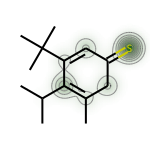

In [206]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import io
from PIL import Image

def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img


smiles = 'CC1=C(C(C)C)C(C(C)(C)C)=CC(=S)[CH]1'
mol = Chem.MolFromSmiles(smiles)

d = rdMolDraw2D.MolDraw2DCairo(150, 150)
do = rdMolDraw2D.MolDrawOptions()
do.fixedBondLengt
d.SetDrawOptions(do)
SimilarityMaps.GetSimilarityMapFromWeights(mol, df_spin_symbol[df_spin_symbol.smiles == smiles].fractional_spin.values.tolist(), draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

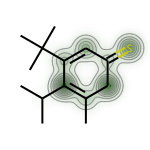

In [198]:
d = rdMolDraw2D.MolDraw2DCairo(150, 150)
SimilarityMaps.GetSimilarityMapFromWeights(mol, df_spin_symbol[df_spin_symbol.smiles == smiles]['pred fractional spin'].values.tolist(), draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

In [ ]:
d.WriteDrawingText()

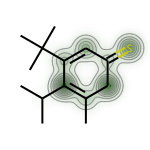

In [141]:
df_renamed

,smiles,err_smiles,ionization energy,pred ionization energy,electron affinity,pred electron affinity,stability,pred stability,err ionization energy,err electron affinity,err stability,correct_max_spin_prediction
4,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)C,CC(=C(C(O)=C[O])C(C)(C)C)C(C)C,0.843045,0.559023,-0.576871,-0.463751,85.102481,100.055583,0.284022,-0.113120,-14.953102,False
5,C/C(=C(O)\C(=C(/C)[O])C(C)(C)C)C(C)C,CC([O])=C(C(O)=C(C)C(C)C)C(C)(C)C,0.677467,0.776560,-0.235511,-0.270637,91.446961,102.624856,-0.099093,0.035126,-11.177895,False
30,C/C(C(N)=O)=C(C)\C(=C(\[O])O)C(C)(C)C,CC(C(N)=O)=C(C)C(=C([O])O)C(C)(C)C,NaN,1.166698,-0.346912,-0.062621,88.911179,100.988925,NaN,-0.284292,-12.077746,True
32,C/C(C=O)=C(C)/C(=C(/[O])C1CC1)C(C)C,CC(C=O)=C(C)C(=C([O])C1CC1)C(C)C,1.222826,1.186033,-0.089117,-0.024895,93.541714,100.276147,0.036793,-0.064222,-6.734432,True
33,C/C(C=O)=C(C)/C(=C(\C)[O])C(C)(C)C,CC([O])=C(C(C)=C(C)C=O)C(C)(C)C,NaN,1.058777,-0.165688,-0.011063,93.663145,108.651088,NaN,-0.154625,-14.987943,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3638,C[CH]C1=C(C(C)(C)N)C(C)=CC(=O)C1=O,C[CH]C1=C(C(C)(C)N)C(C)=CC(=O)C1=O,1.230853,1.016252,0.032216,-0.324794,101.511778,104.959697,0.214601,0.357010,-3.447920,True
3639,C[CH]C1=C(C(C)C)C(C)=CC(=O)C1=S,C[CH]C1=C(C(C)C)C(C)=CC(=O)C1=S,1.132976,0.958905,NaN,-0.384599,98.583733,103.010062,0.174071,NaN,-4.426329,True
3648,Cc1c(C(C)(C)C)c([O])n2c1CC(=O)C2,Cc1c(C(C)(C)C)c([O])n2c1CC(=O)C2,0.473440,0.721269,-0.661470,-0.321654,88.308906,100.017518,-0.247829,-0.339816,-11.708613,False
3679,O=C1OCC=C2CC[CH]C(CCCS)=C12,O=C1OCC=C2CC[CH]C(CCCS)=C12,0.818310,0.803640,-0.379184,-0.352650,97.037679,100.400118,0.014670,-0.026534,-3.362438,True


In [142]:
df_renamed['mol'] = df_renamed.smiles.apply(Chem.MolFromSmiles)

In [174]:
smarts = rdkit.Chem.MolFromSmarts('[O;X1v1+0][CR0]=[CR0]')
keto_radical = df_renamed[df_renamed['mol'].apply(lambda x: x.HasSubstructMatch(smarts))]

In [175]:
keto_radical.shape

(496, 13)

Text(0, 0.5, 'ML')

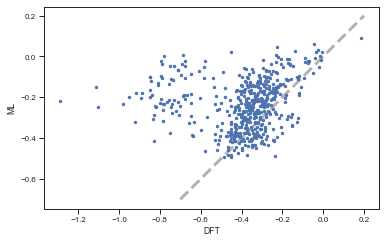

In [176]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, aspect='equal')
plt.plot(keto_radical['electron affinity'], keto_radical['pred electron affinity'], '.')
plt.plot([-.7, .2], [-.7, 0.2], '--', zorder=0, lw=3, color='.7')
plt.xlabel('DFT')
plt.ylabel('ML')

In [179]:
keto_radical.reindex(keto_radical['err electron affinity'].abs().sort_values().index).head(10)

,smiles,err_smiles,ionization energy,pred ionization energy,electron affinity,pred electron affinity,stability,pred stability,err ionization energy,err electron affinity,err stability,correct_max_spin_prediction,mol
2030,CC(C)=C(/C(=C\[O])C(C)(C)C)C1CC1,CC(C)=C(C(=C[O])C(C)(C)C)C1CC1,0.844296,0.832241,-0.269497,-0.269141,94.038475,103.141260,0.012055,-0.000357,-9.102786,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b20805ee0>
3443,CCCCC(C)(C)/C(=C\[O])C(C)(C)NC,CCCCC(C)(C)C(=C[O])C(C)(C)NC,NaN,1.187796,-0.319212,-0.319679,96.113844,104.540363,NaN,0.000467,-8.426519,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b2086c490>
295,C/C=C(C)\C(=C(\[O])C(=O)CC)C(C)(C)C,CC=C(C)C(=C([O])C(=O)CC)C(C)(C)C,0.984133,1.160184,-0.012273,-0.015800,96.515779,105.976990,-0.176051,0.003527,-9.461212,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b20696990>
2469,CC/C=C(CO)/C(=C(\C)[O])C(C)(C)C,CCC=C(CO)C(=C(C)[O])C(C)(C)C,0.648569,0.814663,-0.277742,-0.281303,92.164275,103.655231,-0.166094,0.003561,-11.490956,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b207ec170>
312,C/C=C(C)\C(=C(\[O])CCO)C(C)(C)C,CC=C(C)C(=C([O])CCO)C(C)(C)C,NaN,0.937428,-0.182858,-0.186774,96.126227,102.186912,NaN,0.003916,-6.060685,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b20760710>
3364,CCCC(C)(C)/C(=C\[O])C(C)(C)NC,CCCC(C)(C)C(=C[O])C(C)(C)NC,NaN,1.181566,-0.320327,-0.325324,96.114370,104.355121,NaN,0.004997,-8.240751,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b206f51c0>
307,C/C=C(C)\C(=C(\[O])CCC)C(C)(C)C,CC=C(C)C(=C([O])CCC)C(C)(C)C,NaN,0.811767,-0.380953,-0.375818,95.436932,102.778931,NaN,-0.005135,-7.342000,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b208efd00>
1373,C=C1CCCCCC(/C(C)=C/[O])=C\1CC,C=C1CCCCCC(C(C)=C[O])=C1CC,0.694283,0.935922,-0.311511,-0.305341,88.885015,100.099811,-0.241639,-0.006170,-11.214797,False,<rdkit.Chem.rdchem.Mol object at 0x7f1b20873300>
2306,CC/C(C)=C(C)/C(=C(/[O])CC)C(C)(C)C,CCC(C)=C(C)C(=C([O])CC)C(C)(C)C,NaN,0.589099,-0.465796,-0.458888,96.056312,100.254974,NaN,-0.006909,-4.198662,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b207f2530>
408,C/C=C(CO)/C(=C(/[O])C1CC1)C(C)(C)C,CC=C(CO)C(=C([O])C1CC1)C(C)(C)C,0.648215,0.863890,-0.372790,-0.365632,90.756611,101.879693,-0.215675,-0.007158,-11.123082,True,<rdkit.Chem.rdchem.Mol object at 0x7f1b20763a80>
